<a href="https://colab.research.google.com/github/tylerwalkerbrown/Deep_Learning/blob/main/Fake_News_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notes
Change Runtime to GPU in Runtime Settings 

## Packages needed for twitter 

In [ ]:
import pandas as pd
api_details = pd.read_csv("twitter_access.csv")
#Packages 
import os
from credentials import *
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd 
import numpy as np 
import re 
import matplotlib.pyplot as plt
apikeysecret = str(api_details['Value'][0])
accesstoken = str(api_details['Value'][1])
bear = str(api_details['Value'][2])
Accesstokensecret = str(api_details['Value'][3])
apikey = str(api_details['Value'][4])

## Packages Need for Deeplearning

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
#Feed model layers
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
#Cross validation train,test,valid
from sklearn.model_selection import train_test_split
#Model eval
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix 

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk
import re
from wordcloud import WordCloud

## Importing Data

In [ ]:
#Real news 
real = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv')

#Fake news 
fake = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv')

# Explore The Fake 

In [ ]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [ ]:
fake.subject.value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

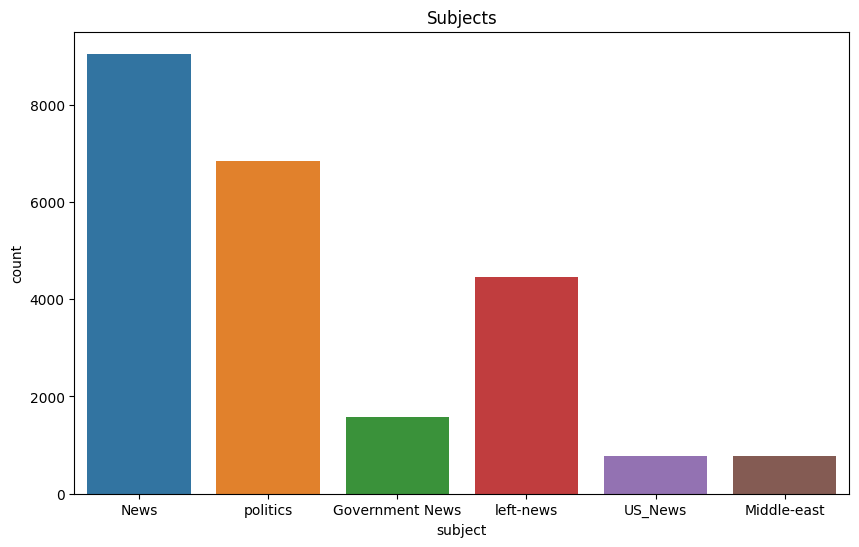

In [ ]:
#PLotting the distribution of Subjects
plt.figure( figsize = (10,6))
sns.countplot(x = 'subject',data = fake)
plt.title("Subjects")
plt.show()

## Word Clouds
- Plots out most common words 

In [ ]:
# Turn the column into list and joining the list to make a large string of data
word_cloud_real = WordCloud().generate(''.join(real['text'].to_list()))
word_cloud_fake = WordCloud().generate(''.join(fake['text'].to_list()))

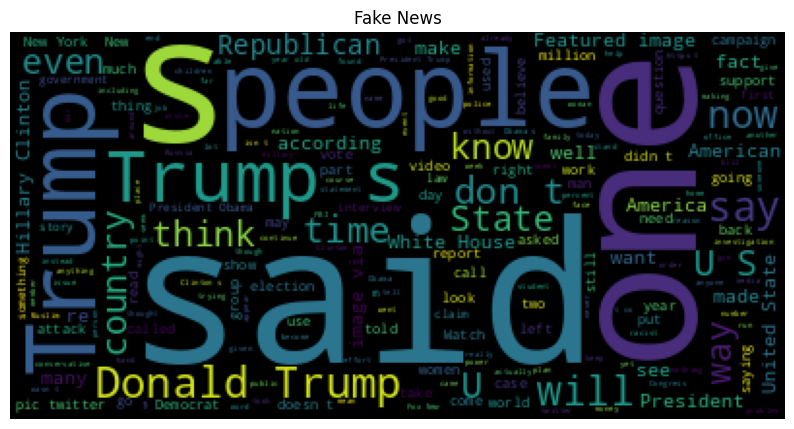

In [ ]:
# Plotting wordcloud for Fake news 
plt.figure( figsize = (10,6))
plt.imshow(word_cloud_fake)
plt.axis("off")
plt.title("Fake News")
plt.show()

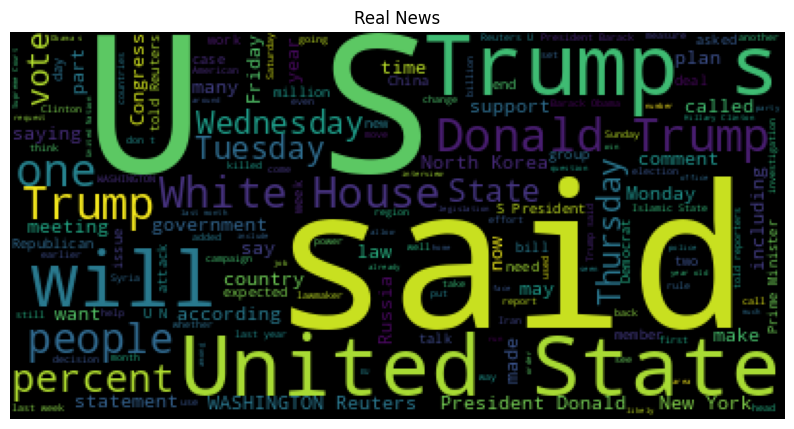

In [ ]:
# Plotting wordcloud for Real news 
plt.figure( figsize = (10,6))
# Turn the column into list and joining the list to make a large string of data
plt.imshow(word_cloud_real)
plt.axis("off")
plt.title("Real News")
plt.show()

## Data Cleansing 

In [ ]:
not_publishers = []
for i, row in enumerate(real.text.values):
  try: 
    record = row.split('-', maxsplit = 1)
    record[1]
    assert(len(record[0]) < 120)
  except:
    #Passes the one that did not pass the test into empty list
    not_publishers.append(i)

In [ ]:
len(not_publishers)

222

In [ ]:
real.iloc[not_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [ ]:
real = real.drop(8970)

In [ ]:
#Extracting the publisher and text with indexes after split
publisher = []
tmp_text = []

for i, row in enumerate(real.text.values):
  if i in not_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')
    continue
  else:
    record = row.split('-', maxsplit = 1)
    #Splitting and indexing the first split thwo will show our data of the publisher
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [ ]:
real['publisher'] = publisher
real['text'] = tmp_text

In [ ]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


### Fake Cleaning

In [ ]:
null_fake = [i for i , text in enumerate(fake.text.tolist()) if str(text).strip() == ""]

In [ ]:
# Working with the fake dataset with null values 
fake.iloc[null_fake]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [ ]:
# Adding the title to the text
real['text'] = real['title'] + ' ' + real.text
fake['text'] = fake['title'] + ' ' + fake.text

In [ ]:
# Changing case size 
real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

# Pre-processing

In [ ]:
real['class'] = 1
fake['class'] = 0

In [ ]:
real = real[['text','class']]
fake = fake[['text','class']]

In [ ]:
data = real.append(fake, ignore_index = True)

<ipython-input-119-1e131b94b4a5>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = real.append(fake, ignore_index = True)


# Removing Characters to Get Raw Words

- import dependencies from : https://github.com/laxmimerit/preprocess_kgptalkie

!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

In [ ]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = ps.remove_rt(x)
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [ ]:
import preprocess_kgptalkie as ps

In [ ]:
data['text'] = data.text.apply(lambda x: ps.remove_special_chars(x))

# Vectorize Text Data (Numerical)

In [ ]:
import gensim 

In [ ]:
y = data['class'].values
# Converting each value of sting into list
x = [d.split() for d in data['text'].tolist()]

### Vectorizing 
- Allows you to analyze the words as numerics 
- Allows you to look at simliar words 

In [ ]:
# Words will be converted into a dimension of 100 
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences = x, vector_size = DIM , window = 10 , min_count = 1)

In [ ]:
#Vecotr values for trump
w2v_model.wv['trump']

array([-4.35502559e-01, -1.14173055e+00, -1.58150029e+00,  3.85140508e-01,
       -2.21780229e+00, -2.07090163e+00, -3.21893811e+00, -4.17990637e+00,
        2.03781748e+00,  1.05443728e+00,  2.99480247e+00, -1.61523736e+00,
       -1.30659592e+00, -1.31329215e+00,  4.71497488e+00,  8.14985561e+00,
        4.38343382e+00,  1.60798597e+00,  1.79459739e+00,  1.08945203e+00,
        1.97797507e-01,  1.88461065e+00,  1.80200195e+00,  4.33738327e+00,
       -1.14715123e+00,  2.25077748e+00, -8.56702745e-01, -1.28195548e+00,
        1.15062892e-01,  1.52908850e+00,  6.22724891e-01, -8.15962374e-01,
       -1.63252342e+00, -1.43900263e+00,  6.43054843e-01, -1.03754506e-01,
       -6.53431082e+00,  4.66607475e+00, -7.30664682e+00, -3.33578992e+00,
       -5.05929768e-01,  1.23236144e+00, -2.00980949e+00, -1.29888761e+00,
       -3.51226234e+00, -1.57712889e+00, -1.94696569e+00,  3.32127190e+00,
        5.39543867e+00, -1.55257499e+00,  2.74188757e+00,  3.22362447e+00,
       -3.38146806e+00,  

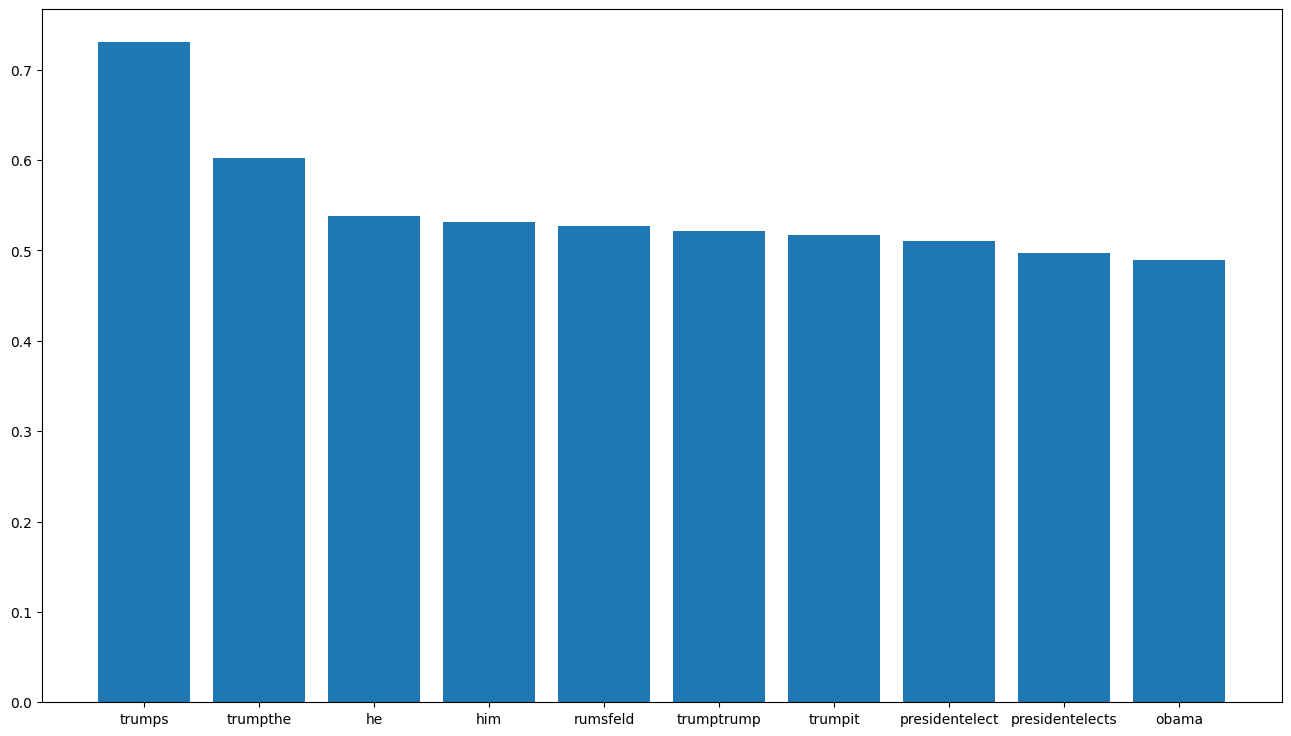

In [ ]:
# Gives you the similarity score 
# Get the most similar words to "trump"
plt.figure( figsize = (16,9))
similar_words = w2v_model.wv.most_similar('trump')
words = [word for word, score in similar_words]
scores = [score for word, score in similar_words]
plt.bar(words, scores)
plt.show()

### Tokenizer 
- Used to create a list of strings into integers 
- Tokenizer then creates unique IDs for each piece of text

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)

In [ ]:
x = tokenizer.texts_to_sequences(x)

In [ ]:
#Able to view the hash table to see sequence and word
#tokenizer.word_index

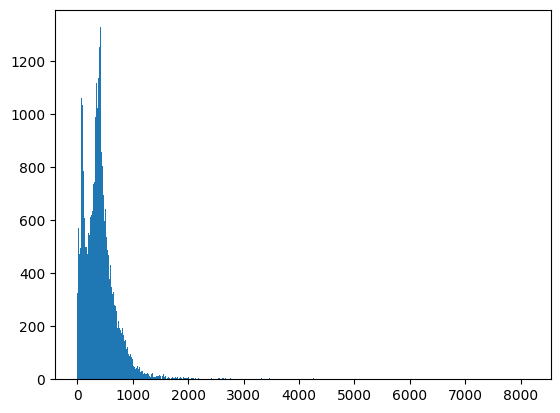

In [ ]:
# How many words are in each row 
plt.hist([len(x) for x in x ] , bins = 700)
plt.show()

In [ ]:
nos = np.array([len(x) for x in x ])
len(nos[nos > 1000])

1581

In [ ]:
# Getting all lengths that are greater than 1000
maxlen = 1000 
x = pad_sequences(x, maxlen = maxlen)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab = tokenizer.word_index

In [ ]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM))
  for word, i in vocab.items():
    weight_matrix[i] = model.wv[word]
  return weight_matrix

In [ ]:
embedding_vectors = get_weight_matrix(w2v_model)

In [ ]:
embedding_vectors.shape

(231873, 100)

#Model 

In [ ]:
#False indictates that the model will not retrain the vector 
# No defined way of doing it 

model = Sequential()
model.add(Embedding(vocab_size, output_dim = DIM, weights = [embedding_vectors], input_length = maxlen, trainable = False))
model.add(LSTM(units = 128))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 700, 100)          23187300  
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,304,677
Trainable params: 117,377
Non-trainable params: 23,187,300
_________________________________________________________________


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y)

In [ ]:
model.fit(x_train, y_train, validation_split=0.3, epochs=6)


Epoch 1/6
737/737 [==============================] - 35s 34ms/step - loss: 0.1445 - acc: 0.9459 - val_loss: 0.0843 - val_acc: 0.9723
Epoch 2/6
737/737 [==============================] - 25s 34ms/step - loss: 0.0600 - acc: 0.9805 - val_loss: 0.0399 - val_acc: 0.9866
Epoch 3/6
737/737 [==============================] - 31s 41ms/step - loss: 0.0408 - acc: 0.9863 - val_loss: 0.0354 - val_acc: 0.9875
Epoch 4/6
737/737 [==============================] - 37s 50ms/step - loss: 0.0289 - acc: 0.9908 - val_loss: 0.0228 - val_acc: 0.9927
Epoch 5/6
737/737 [==============================] - 33s 45ms/step - loss: 0.0189 - acc: 0.9943 - val_loss: 0.0541 - val_acc: 0.9795
Epoch 6/6
737/737 [==============================] - 25s 34ms/step - loss: 0.0120 - acc: 0.9961 - val_loss: 0.0320 - val_acc: 0.9887


# Test Data 

In [ ]:
y_pred = (model.predict(x_test) >= 0.5).astype(int)

351/351 [==============================] - 5s 12ms/step


In [ ]:
accuracy_score(y_test,y_pred)

0.9890423162583519

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5873
           1       0.98      0.99      0.99      5352

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



# New Inputs EX.

In [ ]:
new = """An Illinois judge ruled that the city of Chicago must rehire and pay back lost wages of unionized city employees who were fired or disciplined for violating COVID-19 vaccination requirements.

Administrative law judge Anna Hamburg-Gal, writing on behalf of the Illinois Labor Relations Board, said that the city "failed and refused" to bargain in good faith with union leaders "over the effects of its decision to implement a COVID-19 vaccine mandate."

The decision applies to unionized city of Chicago employees working as carpenters, bricklayers, plumbers, electricians, machinists, and other job categories. 
"""
new = tokenizer.texts_to_sequences(new)
new = pad_sequences(new, maxlen = maxlen)

In [ ]:
if np.sum((model.predict(new) >= 0.5).astype(int)) == 0:
  print("This is fake news.")
else: 
  print("This is real news.")

20/20 [==============================] - 0s 20ms/step
This is fake news.
